# Import the required modules

In [1]:
!pip install git+https://github.com/goolig/dsClass.git

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-qc8gnxrj
  Running command git clone -q https://github.com/goolig/dsClass.git /tmp/pip-req-build-qc8gnxrj
  Resolved https://github.com/goolig/dsClass.git to commit 67567d1d71a8a747c8a68c621045fe53ff139103
     |████████████████████████████████| 278 kB 3.2 MB/s 
  Created wheel for dsClass: filename=dsClass-1.0.27-py3-none-any.whl size=16372733 sha256=d16aabbdc255d70ca71f17dbb76cb535f1b62b0a388229b29c6febb50223a43d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkfbdc78/wheels/cc/7d/ca/f5036d591d94a23e6ab49777866b7fc723500ce0dcdb2a9b2e
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=6a01a0c605c696f05508de7a0a2a25b5c5f0604bbb5144537f18f0cd458e2dd5
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built dsClass pydotplus


In [2]:

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectKBest, SelectFpr
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from dsClass.path_helper import *



# Load the time-series data and lookt at the features statistics

In [3]:
ts_file_path = get_file_path('ts_data.csv')
ts_data = pd.read_csv(ts_file_path)
print(ts_data.shape)
ts_data.head()

(204000, 9)


,d_id,time,bb_count,r-w_rate,reconsects_count,recovbydrv_count,xfer_rate,bb_diffs,fail
0,1,V1,-5,14,0,9,85,0,True
1,1,V2,5,15,0,17,76,0,True
2,1,V3,14,11,0,24,87,0,True
3,1,V4,22,7,0,31,75,0,True
4,1,V5,29,11,0,42,81,0,True


In [4]:
ts_data.groupby('fail').describe()

d_id                                                        \
          count    mean          std    min      25%     50%      75%   
fail                                                                    
False  200000.0  5200.5  2886.758548  201.0  2700.75  5200.5  7700.25   
True     4000.0   100.5    57.741523    1.0    50.75   100.5   150.25   

                bb_count              ... xfer_rate         bb_diffs           \
           max     count        mean  ...       75%    max     count     mean   
fail                                  ...                                       
False  10200.0  200000.0   97.986965  ...      83.0  148.0  200000.0  3.01709   
True     200.0    4000.0  122.358000  ...     104.0  145.0    4000.0  1.04475   

                                           
            std  min  25%  50%  75%   max  
fail                                       
False  2.466513  0.0  1.0  3.0  4.0  22.0  
True   1.390227  0.0  0.0  0.0  2.0   9.0  

[2 rows x 56 columns]

# Plot the time series data

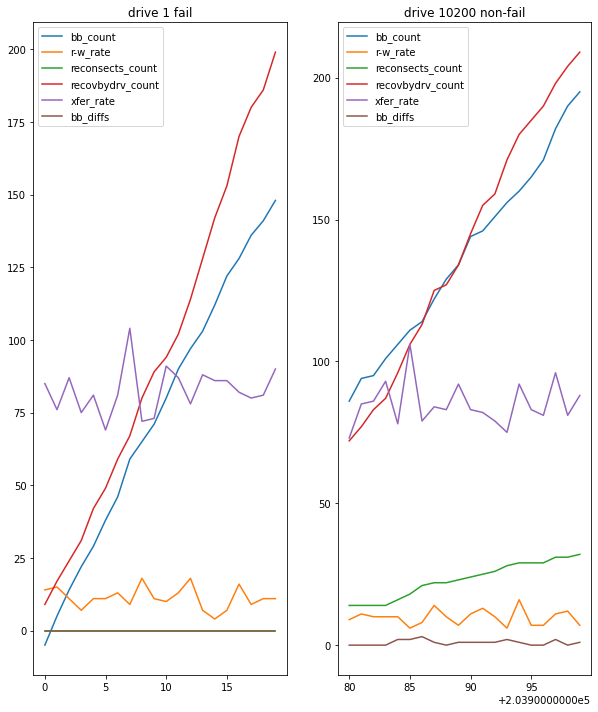

In [5]:
original_features = ['bb_count', 'r-w_rate', 'reconsects_count',
       'recovbydrv_count', 'xfer_rate', 'bb_diffs']

fig, axes = plt.subplots(nrows=1, ncols=2)

ts_data.loc[ts_data['d_id']==1,original_features].plot(figsize=(10,12), title='drive '+str(1)+' fail', ax=axes[0])

num_drives = ts_data['d_id'].unique().shape[0]
#num_drives

ts_data.loc[ts_data['d_id']==num_drives,original_features].plot(figsize=(10,12), title='drive '+str(num_drives)+' non-fail', ax=axes[1])
plt.legend()

# Engineer the time-series features

For each Create the aggregated features (mean, median, variance, minimum and naximum):
* for each sn
* for each feature
* for each aggregation type
        aggregate the 20 daily samples into one aggregated sample  

In [6]:
#Q1
# We created groupby object and joined the outcomes of every function(mean, var...) on it and got big dataframe named q1
data_gb = ts_data.drop(['time'], axis=1).groupby(['d_id','fail'])

q1 = data_gb.mean()
q1 = q1.join(data_gb.median(), lsuffix='_mean', rsuffix = "_median")
q1 = q1.join(data_gb.var(), rsuffix = "_var")
q1 = q1.join(data_gb.min(), rsuffix = "_min")
q1 = q1.join(data_gb.max(),lsuffix='_var', rsuffix = "_max")
# q1 = q1.drop(['fail_median', 'fail_var'], axis=1)
print(q1.columns)
q1

Index(['bb_count_mean', 'r-w_rate_mean', 'reconsects_count_mean',
       'recovbydrv_count_mean', 'xfer_rate_mean', 'bb_diffs_mean',
       'bb_count_median', 'r-w_rate_median', 'reconsects_count_median',
       'recovbydrv_count_median', 'xfer_rate_median', 'bb_diffs_median',
       'bb_count_var', 'r-w_rate_var', 'reconsects_count_var',
       'recovbydrv_count_var', 'xfer_rate_var', 'bb_diffs_var', 'bb_count_min',
       'r-w_rate_min', 'reconsects_count_min', 'recovbydrv_count_min',
       'xfer_rate_min', 'bb_diffs_min', 'bb_count_max', 'r-w_rate_max',
       'reconsects_count_max', 'recovbydrv_count_max', 'xfer_rate_max',
       'bb_diffs_max'],
      dtype='object')


,,bb_count_mean,r-w_rate_mean,reconsects_count_mean,recovbydrv_count_mean,xfer_rate_mean,bb_diffs_mean,bb_count_median,r-w_rate_median,reconsects_count_median,recovbydrv_count_median,...,reconsects_count_min,recovbydrv_count_min,xfer_rate_min,bb_diffs_min,bb_count_max,r-w_rate_max,reconsects_count_max,recovbydrv_count_max,xfer_rate_max,bb_diffs_max
d_id,fail,,,,,,,,,,,,,,,,,,,,,
1,True,75.05,11.30,0.00,96.75,82.60,0.00,75.5,11.0,0.0,91.5,...,0,9,69,0,148,18,0,199,104,0
2,True,102.35,18.80,3.00,121.70,82.55,0.00,97.0,18.0,3.0,124.0,...,3,35,69,0,173,27,3,209,100,0
3,True,153.30,20.00,5.00,166.00,93.90,0.00,152.0,21.5,5.0,170.0,...,5,51,77,0,249,28,5,284,104,0
4,True,96.05,20.00,-2.00,154.90,112.85,0.00,99.0,19.5,-2.0,151.5,...,-2,3,94,0,202,25,-2,322,134,0
5,True,140.45,9.55,29.05,149.15,94.75,2.50,146.0,9.5,31.5,145.0,...,6,42,71,0,230,20,53,265,117,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,False,110.00,8.55,12.15,146.40,87.10,0.65,115.5,8.0,13.5,146.5,...,6,20,69,0,196,18,18,279,103,2
10197,False,123.40,15.20,53.55,58.55,82.50,4.80,127.0,15.5,53.0,63.5,...,10,28,70,1,214,27,103,82,98,10
10198,False,52.95,11.15,31.70,218.70,70.65,2.40,56.5,10.0,32.0,226.0,...,8,41,55,0,76,17,55,380,89,7


# Load the cofiguration data

In [7]:
conf_file_path = get_file_path('conf_data.csv')
conf_data = pd.read_csv(conf_file_path)
conf_data.head()

,d_id,age,capacity,model,fail
0,1,15,1TB,Hitachi,True
1,2,23,1TB,Fujitsu,True
2,3,23,1TB,Seagate,True
3,4,14,1TB,Hitachi,True
4,5,18,600GB,Hitachi,True


# Look at the features\labels distribution

<AxesSubplot:title={'center':'age'}, xlabel='[fail]'>

<Figure size 432x288 with 0 Axes>

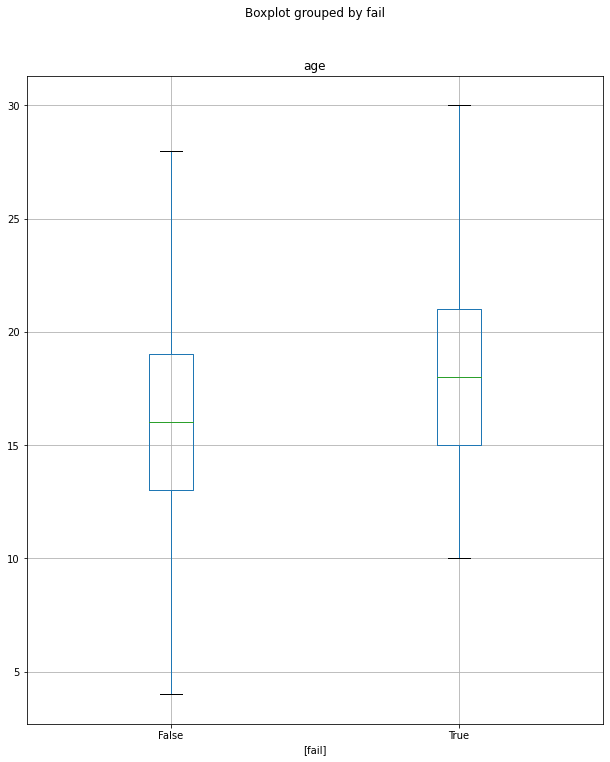

In [8]:
plt.figure()
conf_data[['age', 'fail']].boxplot(by='fail', figsize=(10,12), sym='')

<AxesSubplot:xlabel='model'>

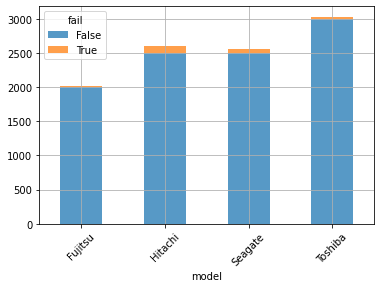

In [9]:
g = conf_data.groupby(["model", "fail"])['d_id'].count().unstack('fail')
g.plot(kind="bar", stacked=True, grid=True, alpha=0.75, rot=45)

# Handle categorical data 

For the decision tree algorithm, map the categorical features to numeric with:
* "Change_capacity" function for "capacity" column
* "pd.get_dummies" function for "model" column


In [10]:
#Q2
# We used the function that we received to change capacity from string to int representation
def change_capacity(data):
    # A function that receives a data frame and a column name as input and map the categorical capacity feature to numeric 
    di = dict(zip(conf_data["capacity"].unique(), [1000, 600, 300]))

    return data.replace({"capacity": di}, inplace=False)

new_conf_data = change_capacity(conf_data)
new_conf_data = pd.get_dummies(new_conf_data)
new_conf_data

,d_id,age,capacity,fail,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba
0,1,15,1000,True,0,1,0,0
1,2,23,1000,True,1,0,0,0
2,3,23,1000,True,0,0,1,0
3,4,14,1000,True,0,1,0,0
4,5,18,600,True,0,1,0,0
...,...,...,...,...,...,...,...,...
10195,10196,16,1000,False,0,0,1,0
10196,10197,25,600,False,0,1,0,0
10197,10198,23,300,False,0,1,0,0
10198,10199,13,600,False,0,0,1,0


# Merge the aggregated time-series and the configuration datasets

In [11]:
#Q3
# We merged on 'd_id' the DF we got from q1 with DF from q2 to DF named q3 and includes all our columns
q3 = q1.merge(new_conf_data, on=['d_id']).drop(['d_id'],axis=1)
fails = q3['fail']
q3 = q3.drop(['fail'],axis=1)
print(q3.columns)
q3

Index(['bb_count_mean', 'r-w_rate_mean', 'reconsects_count_mean',
       'recovbydrv_count_mean', 'xfer_rate_mean', 'bb_diffs_mean',
       'bb_count_median', 'r-w_rate_median', 'reconsects_count_median',
       'recovbydrv_count_median', 'xfer_rate_median', 'bb_diffs_median',
       'bb_count_var', 'r-w_rate_var', 'reconsects_count_var',
       'recovbydrv_count_var', 'xfer_rate_var', 'bb_diffs_var', 'bb_count_min',
       'r-w_rate_min', 'reconsects_count_min', 'recovbydrv_count_min',
       'xfer_rate_min', 'bb_diffs_min', 'bb_count_max', 'r-w_rate_max',
       'reconsects_count_max', 'recovbydrv_count_max', 'xfer_rate_max',
       'bb_diffs_max', 'age', 'capacity', 'model_Fujitsu', 'model_Hitachi',
       'model_Seagate', 'model_Toshiba'],
      dtype='object')


,bb_count_mean,r-w_rate_mean,reconsects_count_mean,recovbydrv_count_mean,xfer_rate_mean,bb_diffs_mean,bb_count_median,r-w_rate_median,reconsects_count_median,recovbydrv_count_median,...,reconsects_count_max,recovbydrv_count_max,xfer_rate_max,bb_diffs_max,age,capacity,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba
0,75.05,11.30,0.00,96.75,82.60,0.00,75.5,11.0,0.0,91.5,...,0,199,104,0,15,1000,0,1,0,0
1,102.35,18.80,3.00,121.70,82.55,0.00,97.0,18.0,3.0,124.0,...,3,209,100,0,23,1000,1,0,0,0
2,153.30,20.00,5.00,166.00,93.90,0.00,152.0,21.5,5.0,170.0,...,5,284,104,0,23,1000,0,0,1,0
3,96.05,20.00,-2.00,154.90,112.85,0.00,99.0,19.5,-2.0,151.5,...,-2,322,134,0,14,1000,0,1,0,0
4,140.45,9.55,29.05,149.15,94.75,2.50,146.0,9.5,31.5,145.0,...,53,265,117,7,18,600,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,110.00,8.55,12.15,146.40,87.10,0.65,115.5,8.0,13.5,146.5,...,18,279,103,2,16,1000,0,0,1,0
10196,123.40,15.20,53.55,58.55,82.50,4.80,127.0,15.5,53.0,63.5,...,103,82,98,10,25,600,0,1,0,0
10197,52.95,11.15,31.70,218.70,70.65,2.40,56.5,10.0,32.0,226.0,...,55,380,89,7,23,300,0,1,0,0
10198,89.50,6.90,50.25,151.80,62.40,4.10,88.0,7.5,50.0,153.5,...,90,267,76,8,13,600,0,0,1,0


# Select the 10 most informative features and transform the data

In [12]:
#Q4

# We apply SelectKBest class to extract top 10 best features from our merged DF q3
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(q3,fails)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(q3.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
fit_trans = bestfeatures.fit_transform(q3,fails)
fit_trans

                    Specs        Score
4          xfer_rate_mean  1029.216835
10       xfer_rate_median  1002.944099
28          xfer_rate_max   883.997173
22          xfer_rate_min   866.972330
20   reconsects_count_min   515.916407
1           r-w_rate_mean   478.533113
7         r-w_rate_median   469.299498
19           r-w_rate_min   409.775864
25           r-w_rate_max   376.424183
2   reconsects_count_mean   338.074517


array([[ 11.3 ,   0.  ,  82.6 , ...,  69.  ,  18.  , 104.  ],
       [ 18.8 ,   3.  ,  82.55, ...,  69.  ,  27.  , 100.  ],
       [ 20.  ,   5.  ,  93.9 , ...,  77.  ,  28.  , 104.  ],
       ...,
       [ 11.15,  31.7 ,  70.65, ...,  55.  ,  17.  ,  89.  ],
       [  6.9 ,  50.25,  62.4 , ...,  49.  ,  12.  ,  76.  ],
       [  9.75,  23.1 ,  84.95, ...,  73.  ,  16.  , 106.  ]])

# Train a Decision tree classifier 

Since we are learning and testing on the same set we will limit the maximum depth parameter to 5 to prevent overfitting

In [13]:
#Q5
# In this block split our data to train and test and train our 3 DTC with different depths
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fit_trans, fails, stratify=fails, test_size=0.25)
clf = DecisionTreeClassifier()
clf1 = DecisionTreeClassifier(max_depth=5)
clf2 = DecisionTreeClassifier(max_depth=10)

clf = clf.fit(X_train,y_train)
clf1 = clf1.fit(X_train,y_train)
clf2 = clf2.fit(X_train,y_train)

# Make the prediction and plot the confusion matrix
https://en.wikipedia.org/wiki/Confusion_matrix

* Change "max_depth" paramter to see what happens to model results


              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2500
        True       0.61      0.66      0.63        50

    accuracy                           0.99      2550
   macro avg       0.80      0.83      0.81      2550
weighted avg       0.99      0.99      0.99      2550

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      2500
        True       0.76      0.70      0.73        50

    accuracy                           0.99      2550
   macro avg       0.88      0.85      0.86      2550
weighted avg       0.99      0.99      0.99      2550

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2500
        True       0.67      0.62      0.65        50

    accuracy                           0.99      2550
   macro avg       0.83      0.81      0.82      2550
weighted avg       0.99      0.99      0.99      2550



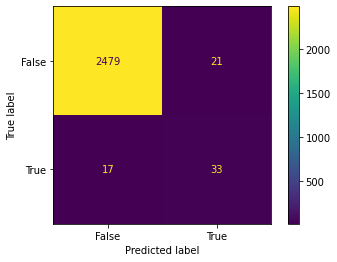

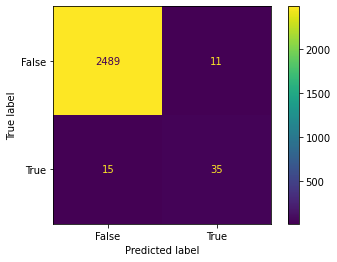

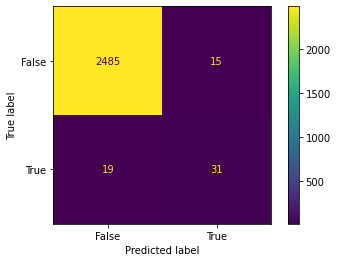

In [14]:
#Q6
# Here we predict our y from x_test and plot our confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

pred = clf1.predict(X_test)
plot_confusion_matrix(clf1,X_test,y_test)
print(classification_report(y_test, pred))

pred = clf2.predict(X_test)
plot_confusion_matrix(clf2,X_test,y_test)
print(classification_report(y_test, pred))

**#Q6 - Continued**

ניסינו להגביל לעומקים שונים: ללא הגבלה 5, 10, וראינו שאין תוצאות משמעותיות לשינויים.
ציפינו לראות אוור פיטינג כשלא שמנו הגבלה אך זה לא קרה, ייתכן בגלל שכמות הדטא לא גדולה מספיק.

# Find the error

Guy claims that if you followed the instruction until Q6 then there is a mistake in the notebook and that we can not rely on the reported performance when information about a new hard drive will arrive

1. Explain in words what is the error 
1. Explain in words what you have to change in order to fix the error
1. Fix the error. Submit a fixed notebook only

**#Q7**

* בגלל שבמרבית הדאטה שקיבלנו הדיסקים תקינים אז הדאטא לא מאוזן ולכן אי אפשר לסמוך על התוצאות
* על מנת לתקן בעיה זו נוסיף דאטא עם תיוג של דיסק פגום וכך נאזן את היחס בין הדיסקים הפגומים


              precision    recall  f1-score   support

       False       0.99      0.99      0.99      2500
        True       0.48      0.64      0.55        50

    accuracy                           0.98      2550
   macro avg       0.74      0.81      0.77      2550
weighted avg       0.98      0.98      0.98      2550

              precision    recall  f1-score   support

       False       1.00      0.97      0.98      2500
        True       0.35      0.80      0.49        50

    accuracy                           0.97      2550
   macro avg       0.67      0.89      0.74      2550
weighted avg       0.98      0.97      0.97      2550

              precision    recall  f1-score   support

       False       0.99      0.98      0.99      2500
        True       0.44      0.68      0.53        50

    accuracy                           0.98      2550
   macro avg       0.71      0.83      0.76      2550
weighted avg       0.98      0.98      0.98      2550



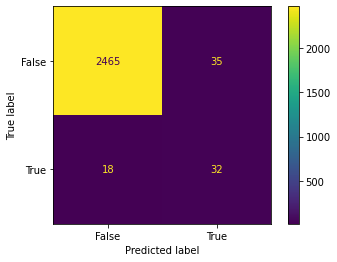

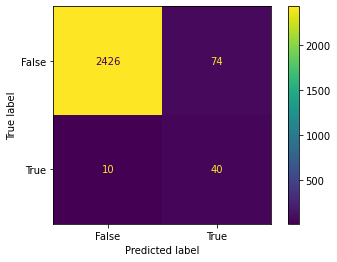

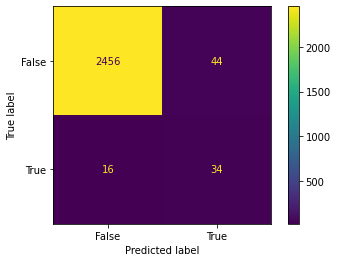

In [15]:
from imblearn.over_sampling import SMOTE
# In this question we use the smote class to balance our train data so our small class will be balanced with the big class so we will have more accurate prediction
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)
X_restest, y_restest = sm.fit_resample(X_test, y_test)

clf = clf.fit(X_res, y_res)
clf1 = clf1.fit(X_res, y_res)
clf2 = clf2.fit(X_res, y_res)

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

pred = clf1.predict(X_test)
plot_confusion_matrix(clf1,X_test,y_test)
print(classification_report(y_test, pred))

pred = clf2.predict(X_test)
plot_confusion_matrix(clf2,X_test,y_test)
print(classification_report(y_test, pred))

# Improving the results
Find an improvment which will increase the performance in terms of model's accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Explain in words what did you change, document the results before and after you suggested improvment

Accuracy of rf classifier on training set: 0.99
Accuracy of rf classifier on test set: 0.97
              precision    recall  f1-score   support

       False       1.00      0.97      0.99      2500
        True       0.38      0.78      0.51        50

    accuracy                           0.97      2550
   macro avg       0.69      0.88      0.75      2550
weighted avg       0.98      0.97      0.98      2550

Accuracy of rf classifier on training set: 1.00
Accuracy of rf classifier on test set: 0.98
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      2500
        True       0.54      0.80      0.65        50

    accuracy                           0.98      2550
   macro avg       0.77      0.89      0.82      2550
weighted avg       0.99      0.98      0.98      2550



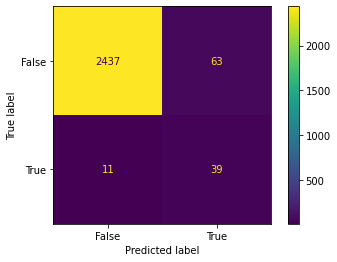

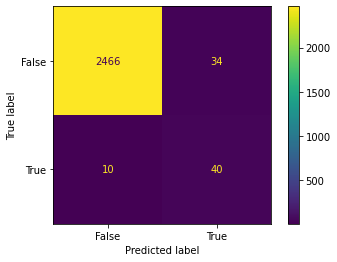

In [16]:
#Q8
# In this question we used different models to train on our data to see who will achieve the best results and present the outcomes with accuracy and confusion matrix
# In this specific model(Random forest) we tried 5 different depths
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5)
clf.fit(X_res, y_res)  
print('Accuracy of rf classifier on training set: {:.2f}'
     .format(clf.score(X_res, y_res)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(clf.score(X_test,y_test)))

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

clf = RandomForestClassifier(max_depth=10)
clf.fit(X_res, y_res)  
print('Accuracy of rf classifier on training set: {:.2f}'
     .format(clf.score(X_res, y_res)))
print('Accuracy of rf classifier on test set: {:.2f}'
     .format(clf.score(X_test,y_test)))

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.97
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      2500
        True       0.54      0.80      0.65        50

    accuracy                           0.98      2550
   macro avg       0.77      0.89      0.82      2550
weighted avg       0.99      0.98      0.98      2550



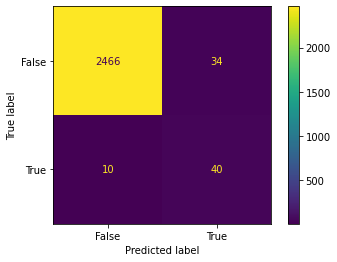

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_res, y_res)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_res, y_res)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))


Accuracy of GNB classifier on training set: 0.97
Accuracy of GNB classifier on test set: 0.96
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      2500
        True       0.54      0.80      0.65        50

    accuracy                           0.98      2550
   macro avg       0.77      0.89      0.82      2550
weighted avg       0.99      0.98      0.98      2550



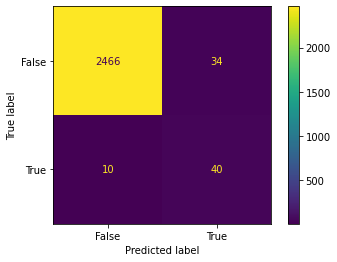

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_res, y_res)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_res, y_res)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

Accuracy of XGBClassifier classifier on training set: 1.00
Accuracy of XGBClassifier classifier on test set: 0.98
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      2500
        True       0.49      0.76      0.60        50

    accuracy                           0.98      2550
   macro avg       0.74      0.87      0.79      2550
weighted avg       0.99      0.98      0.98      2550



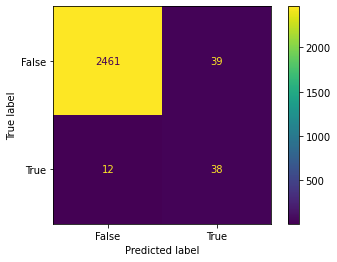

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_res, y_res)
print('Accuracy of XGBClassifier classifier on training set: {:.2f}'
     .format(clf.score(X_res, y_res)))
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

pred = clf.predict(X_test)
plot_confusion_matrix(clf,X_test,y_test)
print(classification_report(y_test, pred))

Not all questions will be checked